# Mixture Density Network
### In this notebook, We'll explore uncertainty features using Mixture Density Network.  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import math
%matplotlib inline

### TRAINING DATA

In [2]:
NSAMPLE = 1000

# DATASET: We'll use toy data points for demonstration
x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1)))
y_data = np.float32(np.sin(0.75*x_data)*7.0 + x_data*0.5 + r_data*1.0)

# Define model variables
x = tf.placeholder(dtype=tf.float32, shape=[None,1])
y = tf.placeholder(dtype=tf.float32, shape=[None,1])

NX = 1
NHIDDEN_FIRST = 40
NHIDDEN_OUTPUT = 1

W = {
    "l1": tf.Variable(tf.random_normal([NX, NHIDDEN_FIRST], stddev=1.0, dtype=tf.float32)),
    "l2": tf.Variable(tf.random_normal([NHIDDEN_FIRST, NHIDDEN_OUTPUT], stddev=1.0, dtype=tf.float32))
}
b = {
    "l1": tf.Variable(tf.random_normal([1, NHIDDEN_FIRST], stddev=1.0, dtype=tf.float32)),
    "l2": tf.Variable(tf.random_normal([1,NHIDDEN_OUTPUT], stddev=1.0, dtype=tf.float32))
}

def mlp(_x, _W, _b):
    l1 = tf.nn.tanh(tf.matmul(_x, _W['l1']) + _b['l1'])
    return tf.matmul(l1, _W['l2']) + _b['l2']

# Train Stage
pred = mlp(x, W, b)
loss = tf.nn.l2_loss(pred-y);
optm = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)

# Test Stage
x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size, 1)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    NEPOCH = 1000
    for i in range(NEPOCH):
        sess.run(optm, feed_dict={x: x_data, y: y_data})
    print ("OPTIMIZATION FINISHED")
    y_test = sess.run(pred, feed_dict={x: x_test})
    print ("TEST FINISHED")

OPTIMIZATION FINISHED
TEST FINISHED


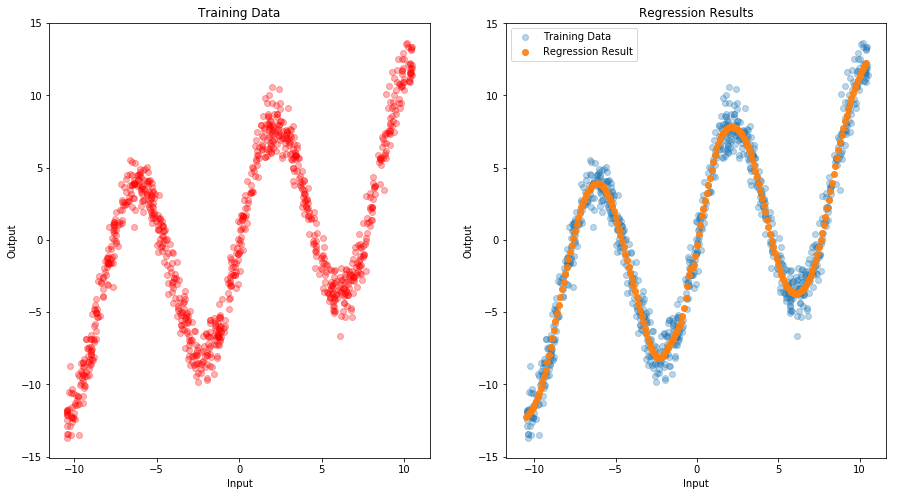

In [3]:
# Visualize result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

ax1.plot(x_data, y_data, 'ro', alpha=0.3)
ax1.set_title("Training Data")
ax1.set_xlabel("Input")
ax1.set_ylabel("Output")

ax2.scatter(x_data,y_data,alpha=0.3)
ax2.scatter(x_test,y_test,alpha=0.9)
ax2.legend(["Training Data", "Regression Result"])
ax2.set_title("Regression Results")
ax2.set_xlabel("Input")
ax2.set_ylabel("Output")
plt.show()

Looks good to me, now let's flip the data

## GET NEW TRAINING DATA BY FLIPPING

In [4]:
NSAMPLE = 1000
r_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
y_data = np.copy(r_data)
n_data = np.float32(np.random.normal(size=(NSAMPLE,1)))
x_data = np.float32(np.sin(0.75*y_data)*7.0 + y_data*0.5 + n_data*0.01)
for i in range(NSAMPLE): # ADD NOISE 
    y_data[i] = r_data[i] + 0.05*(x_data[i]+30)*n_data[i]

# Test Stage
x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size, 1)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    NEPOCH = 1000
    for i in range(NEPOCH):
        sess.run(optm, feed_dict={x: x_data, y: y_data})
    print ("OPTIMIZATION FINISHED")
    y_test = sess.run(pred, feed_dict={x: x_test})
    print ("TEST FINISHED")

OPTIMIZATION FINISHED
TEST FINISHED


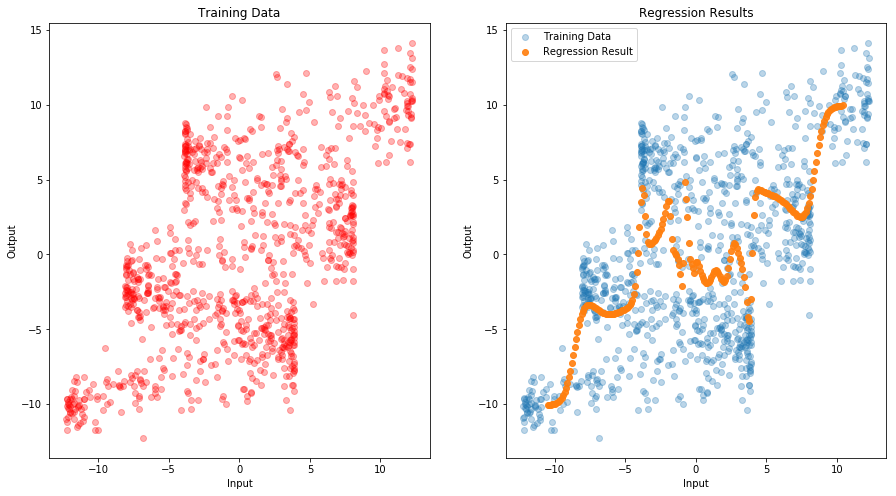

In [7]:
# Visualize result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

ax1.plot(x_data, y_data, 'ro', alpha=0.3)
ax1.set_title("Training Data")
ax1.set_xlabel("Input")
ax1.set_ylabel("Output")

ax2.scatter(x_data,y_data,alpha=0.3)
ax2.scatter(x_test,y_test,alpha=0.9)
ax2.legend(["Training Data", "Regression Result"])
ax2.set_title("Regression Results")
ax2.set_xlabel("Input")
ax2.set_ylabel("Output")
plt.show()

Sure it doesn't work this way. 

## NOW, USE MIXTURE DENSITY NETWORK

In [22]:
NHIDDEN = 85
STDEV   = 0.1
KMIX    = 20 # NUMBER OF MIXTURES
NOUT    = KMIX * 3 # PI / MU / STD

x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")
Wmdn = {
    "l1": tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32)),
    "l2": tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
}
bmdn = {
    "l1": tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32)),
    "l2": tf.Variable(tf.random_uniform([1,NOUT], minval=-10, maxval=10, dtype=tf.float32))
}

def mdn(_x, _W, _b):
    sig_gain = 1
    _l1  = tf.nn.tanh(tf.matmul(_x, _W['l1']) + _b['l1'])
    _out = tf.matmul(_l1, _W['l2']) + _b['l2']
    
    # CONVERT OUTPUT. split output units into 
    # ([pi1, pi2 ...pik], [sigma1, sigma2 ...sigmak], [mu1, mu2 ...muk])
    _out_pi_hat, _out_sigma_hat, _out_mu = tf.split(_out, 3, 1)
    
    
    # APPLY SOFTMAX, HEURISTICS APPLIED on _out_pi, it'll represent weight of each mixture.
    # Thus, sum(pi) should strictly be 1. 
    _out_pi = tf.nn.softmax(_out_pi_hat)
    _out_sigma = tf.nn.sigmoid(_out_sigma_hat)
    """
    _out_pi_hat = tf.exp(_out_pi_hat - tf.reduce_max(_out_pi_hat, 1, keep_dims=True))
    _nor_pi = tf.reciprocal(tf.reduce_sum(_out_pi_hat, 1, keep_dims=True))
    _out_pi = tf.multiply(_nor_pi, _out_pi_hat)
    _out_sigma = sig_gain*tf.sigmoid(_out_sigma_hat)
    """
    return _out_pi, _out_sigma, _out_mu

out_pi, out_sigma, out_mu = mdn(x, Wmdn, bmdn)

# Aleatoric, Epistemic uncertainty matrix function

In [23]:
""" These two function measures overall mixtures' expectation, variance.
Shape of input : ([x, KMIX], [x, KMIX])
Shape of output : [x, 1] """
def np_get_total_expectation(_pi, _mu): 
#    assert _pi.shape != _mu.shape
    return np.sum(np.multiply(_pi, _mu), axis=1) # Weighted sum of all _mu

# And This is nonsense. Should be fixed?
def np_get_total_variance(_pi, _sigma):
    if _pi.shape != _sigma.shape:
        print("shape not maching in np_get_total_variance()")
        return -1
    return np.sum(np.multiply(_pi, _sigma), axis=1) # Weighted sum over all sigmas in mixtures


""" Law of total variance given x : V[y|x] = E(V[y|x, k])+ V(E[y|x, k])
This function calculates total epistemic aleatoric uncertainty given x,
throughout all K mixtures.
Shape of inputs : [KMIX,]
Shape of output : float """
# E(V[y|x, k])
def np_get_total_aleatoric_uncertainty(_pis, _sigmas):
    total_aleatoric_uncertainty = np.sum(np.multiply(_pis, _sigmas))
    return total_aleatoric_uncertainty

# V(E[y|x, k])
def np_get_total_epistemic_uncertainty(_pis, _mus):
    expectation = np.sum(np.multiply(_pis, _mus)) # Real number
    square_deviation = np.square(_mus - expectation) # Broadcast
    total_epistemic_uncertainty = np.sum(np.multiply(_pis, square_deviation))
    return total_epistemic_uncertainty



""" Each Mixture has its own aleatoric, epistemic uncertainty.
Also these two function should be used on 'EACH' sample_x
Shape of input : [KMIX,]
Shape of output : [KMIX,] """
def np_get_aleatoric_uncertainty_k(_sigmas_x):
    aleatoric_uncertainty = _sigmas_x
    return aleatoric_uncertainty
 
def np_get_epistemic_uncertainty_k(_pis_x, _mus_x, total_expectation_x):
    epistemic_uncertainty = np.square(_mus_x - total_expectation_x)
    return epistemic_uncertainty


# Dummy function, It's okay to just use sigma instead of this.
def np_get_aleatoric_uncertainty_matrix(_sigma):
    x_number = _sigma.shape[0]
    KMIX = _sigma.shape[1]
    result = np.zeros((x_number, KMIX))
    
    for x in range(0, x_number):
        result[x] = np_get_aleatoric_uncertainty_k(_sigma[x])

    return result

def np_get_epistemic_uncertainty_matrix(_pi, _mu, _sigma):
    if _pi.shape != _mu.shape:
        print("shape not maching")
        return -1
    x_number = _pi.shape[0]
    KMIX = _pi.shape[1]
    
    result = np.zeros((x_number, KMIX))
    mdn_total_exp = np_get_total_expectation(_pi, _mu)
    
    for x in range(0, x_number):
        result[x] = np_get_epistemic_uncertainty_k(_pi[x], _mu[x], mdn_total_exp[x])

    return result
    
""" Integrated function np_get_alea_epis_uncertainty_matrix():
Shape of 3 inputs : [sample_x, KMIX]
Shape of output : [sample_x, KMIX, 2], each has [aleatoric, epistemic] value as element """
def np_get_alea_epis_uncertainty_matrix(_pi, _mu, _sigma):
    
    if _pi.shape != _mu.shape:
        print("shape not maching in np_alea_epis_uncertainty_matrix()")
        return -1
    
    x_number = _pi.shape[0]
    mixture_number = _pi.shape[1]
    result = np.zeros((x_number, mixture_number, 2))
    
    mdn_total_exp = np_get_total_expectation(_pi, _mu)
    
    for x in range(0, x_number):
        aleatoric_unct = np_get_aleatoric_uncertainty_k(_sigma[x])# => (100, 15) changes into (15, 1),
        epistemic_unct = np_get_epistemic_uncertainty_k(_pi[x], _mu[x], mdn_total_exp[x])# => this also.
        result[x] = np.dstack((aleatoric_unct, epistemic_unct))
 
    return result

def np_get_total_uncertainty_matrix(_pi, _mu, _sigma):
    total_uncertainty_mat = np.zeros((_pi.shape[0], _pi.shape[1]))
    
    # Fetch uncertainty matrix from 3 input matrices
    uncertainty_matrix = np_get_alea_epis_uncertainty_matrix(_pi, _mu, _sigma)
    
    # Need more elegant way to sum aleatoric, epistemic uncertainties
    for i in range(uncertainty_matrix.shape[0]):
        for j in range(uncertainty_matrix.shape[1]):
            total_uncertainty_mat[i, j] = uncertainty_matrix[i, j][0] + uncertainty_matrix[i, j][1]

    return total_uncertainty_mat

## SAMPLING FUNCTIONS

In [24]:
# UNIVARIATE GAUSSIAN MODEL - numpy version
def np_normal(_y, _mu, _sigma):
    _result = (_y-_mu)/_sigma
    _result = -np.square(_result)/2
    _result = np.exp(_result)/(math.sqrt(2*pi)*_sigma)    
    return _result

# This function is used as color intensity on mean trajectory
def np_cover_fixed_minmax(matrix, fixed=0):
    
    # If parameter not given, set max value of matrix to fixed
    if fixed == 0:
        fixed = np.max(matrix)
        
    x_sample = matrix.shape[0]
    kmix = matrix.shape[1]

    normalized_mat = np.copy(matrix)
    first_dummies = np.ones(kmix)*np.min(matrix)
    normalized_mat[0] = first_dummies
    last_dummies = np.ones(kmix)*fixed
    normalized_mat[x_sample-1] = last_dummies
    
    if matrix.shape != normalized_mat.shape:
        print("you went wrong")
    return fixed, normalized_mat
    
    
def get_mixture_idx(_th, _unnormalized_props, mode="prob"):
    
    accumulated = 0
    _normalized_probs = np.zeros(_unnormalized_props.shape)
    
    # Normalize positive properties
    if mode == "prob":
        _unnormalized_probs = _unnormalized_props + 0.0001
        _normalized_probs = _unnormalized_props / np.sum(_unnormalized_props)
    # Reversed normalize (for uncertainty values)
    # For example, 3 mixture of uncertainty values [10, 20, 70] goes to [60, 30, 0], for reasons that 
    # we're trying to get most certain mixtures at high probability
    elif mode == "unct":

        max_uncert = np.max(_unnormalized_props) # get max from uncertainties
        _unnormalized_probs = _unnormalized_props - max_uncert # subtract max from original arr
        _unnormalized_probs = -(_unnormalized_props) # apply negetive
        _unnormalized_probs = _unnormalized_props + 0.0001
        _normalized_probs = _unnormalized_props / np.sum(_unnormalized_props)
    else :
        print("select valid mode : \"prob\" or \"unct\"")
        return -1
    
    for i in range(0, _normalized_probs.size):
        accumulated += _normalized_probs[i]
        if (accumulated >= _th):
            return i
    print ("error with sampling ensemble")
    
""" 
Shape of Input : (x_sample, KMIX) 
Shape of Output : (x_sample, NPOINTS)plottable object, NPOINTS per one sample x"""
def sample_random_points_gmm(_sample_unnormalized_props, _pi, _mu, _sigma, mode, NPOINTS=15):
    NTEST = _sample_unnormalized_props.shape[0]
    result = np.random.rand(NTEST, NPOINTS)
    rn = np.random.randn(NTEST, NPOINTS)
    
    
    # transforms result into random ensembles
    for i in range(0, NTEST):
        for j in range(0, NPOINTS):
            idx = get_mixture_idx(result[i, j], _sample_unnormalized_props[i], mode)
            mu = _mu[i, idx]
            std = _sigma[i, idx]
            result[i, j] = mu + rn[i, j]*std
    return result
    
    
def sample_gmm(x_sample, _out_pi, _out_mu, _out_sigma, NPOINTS=15):
    NTEST  = x_sample.shape[0]
    KMIX = _out_pi.shape[1]
    result_dict = {}
    
    # Meaningless init
    result_pi = np.zeros((NTEST, NPOINTS))
    result_unct_total = np.zeros((NTEST, NPOINTS))
    result_unct_aleatoric = np.zeros((NTEST, NPOINTS))
    result_unct_epistemic = np.zeros((NTEST, NPOINTS))
    result_overall_aleatoric = np.zeros((NTEST, 1))
    result_overall_epistemic = np.zeros((NTEST, 1))
    result_overall_uncertainty = np.zeros((NTEST, 1))
    
    # 
    for x in range(NTEST):
        result_overall_aleatoric[x] = np_get_total_aleatoric_uncertainty(_out_pi[x], _out_sigma[x])
        result_overall_epistemic[x] = np_get_total_epistemic_uncertainty(_out_pi[x], _out_mu[x])
        result_overall_uncertainty[x] = result_overall_aleatoric[x] + result_overall_epistemic[x]
    
    result_dict['result_overall_aleatoric'] = (result_overall_aleatoric / np.max(result_overall_aleatoric))*20 - 10
    result_dict['result_overall_epistemic'] = (result_overall_epistemic / np.max(result_overall_epistemic))*20 - 10
    result_dict['result_overall_uncertainty'] = (result_overall_uncertainty / np.max(result_overall_uncertainty))*20 - 10
    
    total_uncertainty_mat = np_get_total_uncertainty_matrix(_out_pi, _out_mu, _out_sigma)
    aleatoric_uncertainty_mat = np_get_aleatoric_uncertainty_matrix(_out_sigma)
    epistemic_uncertainty_mat = np_get_epistemic_uncertainty_matrix(_out_pi, _out_mu, _out_sigma)
    fixed, result_dict['total_uncertainty_mat'] = np_cover_fixed_minmax(total_uncertainty_mat)
    _, result_dict['alea_uncertainty_mat'] = np_cover_fixed_minmax(aleatoric_uncertainty_mat, fixed)
    _, result_dict['epis_uncertainty_mat'] = np_cover_fixed_minmax(epistemic_uncertainty_mat, fixed)

    result_dict['result_pi'] = sample_random_points_gmm(_out_pi, _out_pi, _out_mu, _out_sigma, mode="prob")
    result_dict['result_unct_total'] = sample_random_points_gmm(total_uncertainty_mat, _out_pi, _out_mu, _out_sigma, mode="unct")
    result_dict['result_unct_aleatoric'] = sample_random_points_gmm(aleatoric_uncertainty_mat, _out_pi, _out_mu, _out_sigma, mode="unct")
    result_dict['result_unct_epistemic'] = sample_random_points_gmm(epistemic_uncertainty_mat, _out_pi, _out_mu, _out_sigma, mode="unct")

    return result_dict
print ("SAMPLING FUNCTION READY")

SAMPLING FUNCTION READY


## TRAIN

/Users/sangsulee/.local/share/virtualenvs/deeplearning-_gE97mQ2/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


START OPTIMIZATION
	In epoch:0,


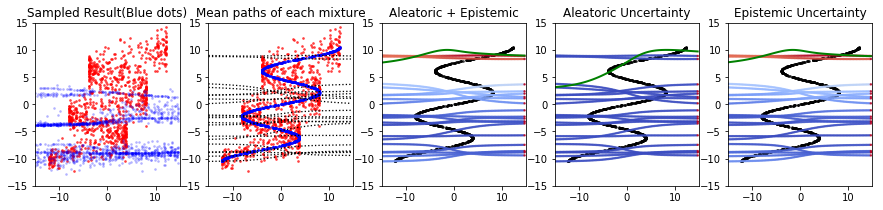

	In epoch:400,


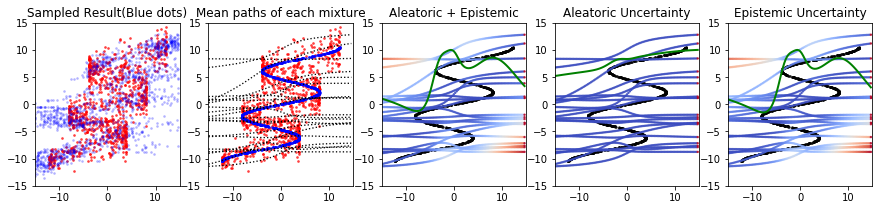

	In epoch:800,


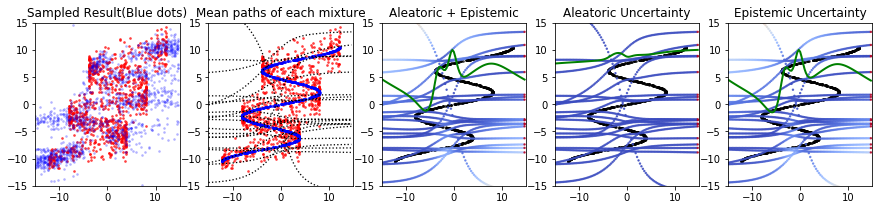

	In epoch:1200,


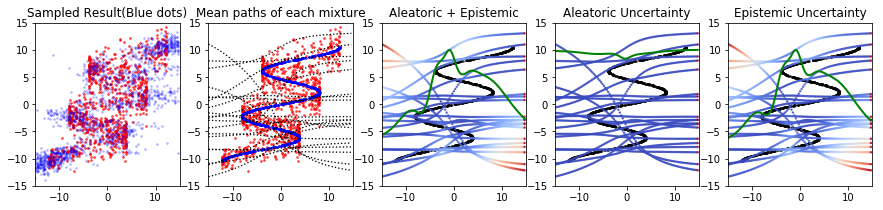

	In epoch:1600,


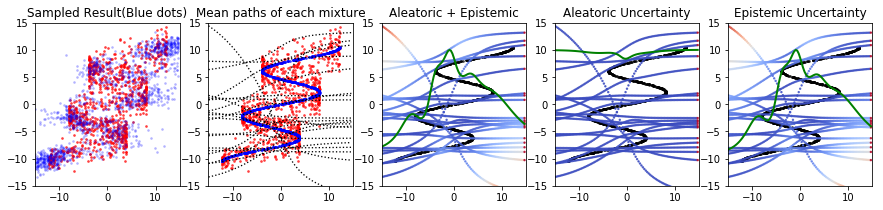

	In epoch:2000,


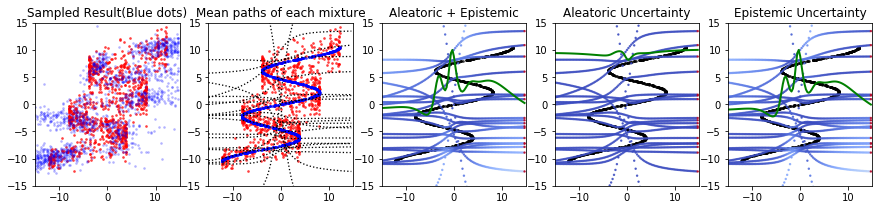

	In epoch:2400,


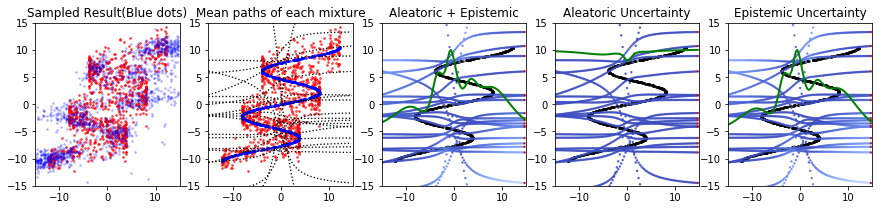

	In epoch:2800,


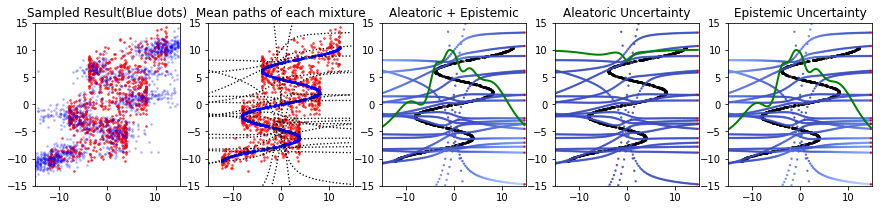

In [25]:
pi = math.pi
# UNIVARIATE GAUSSIAN MODEL
def tf_normal(_y, _mu, _sigma):
    _result = (_y-_mu)/_sigma
    _result = -tf.square(_result)/2
    _result = tf.exp(_result)/(math.sqrt(2*pi)*_sigma)    
    return _result

# GAUSSIAN MIXTURE MODEL - Cost function as Negative Log Likelyhood
def gmm(_y, _out_pi, _out_sigma, _out_mu):
    _probs = tf_normal(_y, _out_mu, _out_sigma)
    _result = tf.multiply(_out_pi, _probs)
    _result = tf.reduce_sum(_result, 1, keep_dims=True)
    return tf.reduce_mean(-tf.log(_result))

# SET LOSS AND OPTIMIZER 
loss = gmm(y, out_pi, out_sigma, out_mu)
optm = tf.train.AdamOptimizer(learning_rate=0.01
            , beta1=0.9, beta2=0.999, epsilon=0.1).minimize(loss)

# OPEN SESSION
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
NEPOCH = 3000

losses = np.zeros(NEPOCH) # store the training progress here.
print ("START OPTIMIZATION")
for epoch in range(NEPOCH):
    feeds = {x: x_data, y: y_data}
    sess.run(optm, feed_dict=feeds)
    losses[epoch] = sess.run(loss, feed_dict=feeds)
    if (epoch%400) == 0:
        print("\tIn epoch:{0},".format(epoch))
        x_sample = np.float32(np.arange(-15, 15, 0.3)).reshape(-1, 1)
        out_pi_test, out_sigma_test, out_mu_test \
            = sess.run([out_pi, out_sigma, out_mu], feed_dict={x: x_sample})
        # Fetch test results for plotting from sampling function
        result_dict = sample_gmm(x_sample, out_pi_test, out_mu_test, out_sigma_test)
        
        (y_prob_test, y_unct_test, y_alea_test, y_epis_test, 
         y_total_unct_mat, y_alea_unct_mat, y_epis_unct_mat) = \
            result_dict['result_pi'], result_dict['result_overall_uncertainty'], result_dict['result_overall_aleatoric'],\
            result_dict['result_overall_epistemic'], result_dict['total_uncertainty_mat'], \
            result_dict['alea_uncertainty_mat'], result_dict['epis_uncertainty_mat']
        
        # PLOT
        f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=False, figsize=(15, 3))
        
        # AX1
        ax1.scatter(x_data, y_data, c='red', s=3, alpha=0.6)
        for i in range(y_prob_test.shape[1]):
            ax1.scatter(x_sample, y_prob_test[:,i], c='blue', s=3, alpha=0.2)
        ax1.set_title("Sampled Result(Blue dots)")
        ax1.axis([-15, 15, -15, 15])
        
        # AX2
        ax2.scatter(x_data, y_data, c='red', s=3, alpha=0.6)
        ax2.scatter(x_data, r_data, c='blue', s=3, alpha=0.6)
        ax2.plot(x_sample, out_mu_test, 'k:', linewidth=1.3, label="Mean Functions")
        ax2.set_title("Mean paths of each mixture")
        ax2.axis([-15, 15, -15, 15])
        
        # AX3
        ax3.scatter(x_data, r_data, c='black', s=3, alpha=0.6)
        for i in range(out_mu_test.shape[1]):
            ax3.scatter(x_sample, out_mu_test[:,i], c=y_total_unct_mat[:,i], cmap="coolwarm", s=2, alpha=0.8)
        l3, = ax3.plot(x_sample, y_unct_test, 'g-', linewidth=2.0, alpha=1)
        ax3.set_title("Aleatoric + Epistemic")
        ax3.axis([-15, 15, -15, 15])
        
        # AX4
        ax4.scatter(x_data, r_data, c='black', s=3, alpha=0.6)
        for i in range(out_mu_test.shape[1]):
            ax4.scatter(x_sample, out_mu_test[:,i], c=y_alea_unct_mat[:,i], cmap="coolwarm", s=2, alpha=0.8)
        l4, = ax4.plot(x_sample, y_alea_test, 'g-', linewidth=2.0, alpha=1)
        ax4.set_title("Aleatoric Uncertainty")
        ax4.axis([-15, 15, -15, 15])
        
        # AX5
        ax5.scatter(x_data, r_data, c='black', s=3, alpha=0.6)
        for i in range(out_mu_test.shape[1]):
            ax5.scatter(x_sample, out_mu_test[:,i], c=y_epis_unct_mat[:,i], cmap="coolwarm", s=2, alpha=0.8)
        l5, = ax5.plot(x_sample, y_epis_test, 'g-', linewidth=2.0, alpha=1)
        ax5.set_title("Epistemic Uncertainty")
        ax5.axis([-15, 15, -15, 15])
        
        plt.show()

# RESULT
### LETS SEE MORE CLOSER

Text(0.5,1,'Loss')

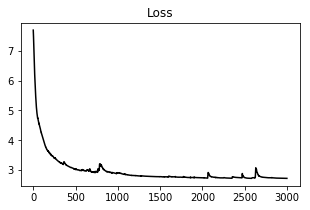

In [21]:
plt.figure(figsize=(5, 3))
plt.plot(losses, 'k-', alpha=1.0)
plt.title("Loss")

NLL Loss decreases pretty well.

## Mean path of each mixture

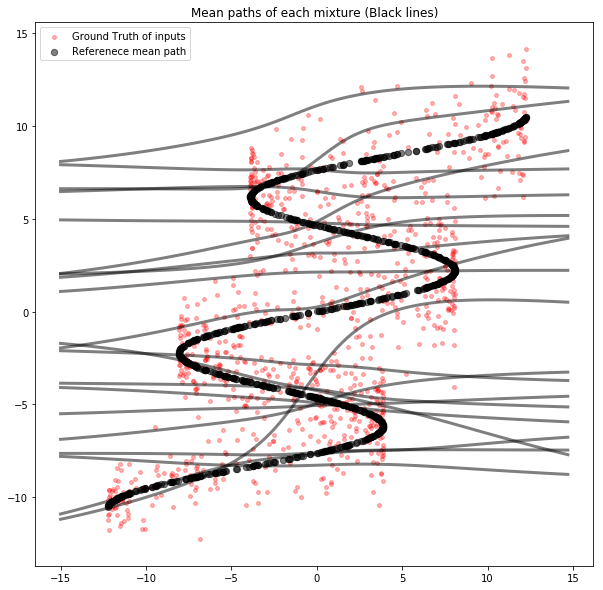

In [17]:
plt.figure(figsize=(10, 10))
plt.title("Mean paths of each mixture (Black lines)")
plt.plot(x_sample, out_mu_test, 'k-', linewidth=3, alpha=0.5)
plt.scatter(x_data, y_data, c='red', s=15, alpha=0.3, label="Ground Truth of inputs")
plt.scatter(x_data, r_data, c='black', s=40, alpha=0.5, label="Referenece mean path")
plt.legend()
plt.show()

It shows Ground Truth inputs(red dots), reference mean values(black dots), and
mean path of each mixture.(gray lines)

From the law of total variance ( V[Y] = V(E[Y|X]) + E(V[Y|X) )
, we'll draw aleatoric and epistemic uncertainties over these mixtures.

## Aleatoric, Epistemic uncertainty

**Aleatoric uncertainty** shows predictive variance, which cannot be reduced with more data.  
In constast, **Epistemic uncertainty** captures our ignorance about predictive model.  
Each term corresponds to E(V[Y|X]), V(E[Y|X]).  

First, we'll decide the single unique values [total(alea+epis), aleatoric, epistemic] on every input x,  
so it could represent all mixtures to one value, on every input x. 

Throughout mixtures, we sum over all mixture probabilities multiplied by pi.


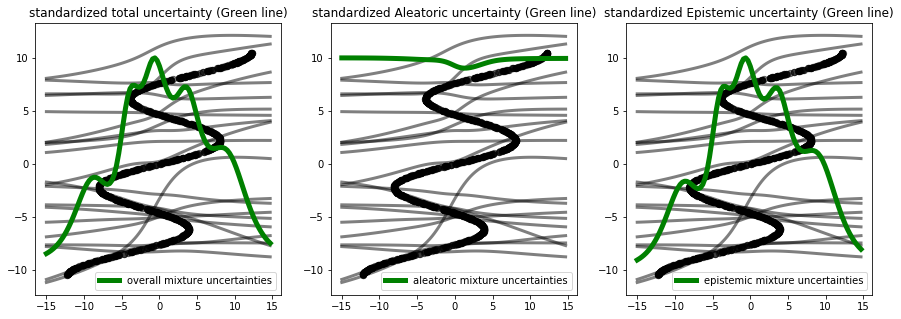

In [18]:
f, (ax_un1, ax_un2, ax_un3) = plt.subplots(1, 3, sharey=False, figsize=(15, 5))
ax_un1.set_title("standardized total uncertainty (Green line)")
ax_un1.plot(x_sample, out_mu_test, 'k-', linewidth=3, alpha=0.5)
ax_un1.scatter(x_data, r_data, c='black', s=40, alpha=0.5)
l_un1, = ax_un1.plot(x_sample, y_unct_test, 'g-', linewidth=5.0, alpha=1, 
         label="overall mixture uncertainties")
ax_un1.legend()

ax_un2.set_title("standardized Aleatoric uncertainty (Green line)")
ax_un2.plot(x_sample, out_mu_test, 'k-', linewidth=3, alpha=0.5)
ax_un2.scatter(x_data, r_data, c='black', s=40, alpha=0.5)
l_un2, = ax_un2.plot(x_sample, y_alea_test, 'g-', linewidth=5.0, alpha=1, 
         label="aleatoric mixture uncertainties")
ax_un2.legend()

ax_un3.set_title("standardized Epistemic uncertainty (Green line)")
ax_un3.plot(x_sample, out_mu_test, 'k-', linewidth=3, alpha=0.5)
ax_un3.scatter(x_data, r_data, c='black', s=40, alpha=0.5)
l_un3, = ax_un3.plot(x_sample, y_epis_test, 'g-', linewidth=5.0, alpha=1, 
         label="epistemic mixture uncertainties")
ax_un3.legend()

plt.show()


As a result of toy problem,  you can check general trend that **Aleatoric uncertainty values ,**  
which are quite smaller than epistemic . Numeric value of **Epistemic uncertainties are located from 5 to 3000.**

In upper graph, for the sake of understanding, we standardized these values to certain range  
so that we can see how these values are changed on sequential inputs (see green lines).

The emphasis of this graph, especially Epistemic uncertainties,  
is that **overall uncertainty values are high when it has multiple answers on single input x.**

On the other hand, aleatoric uncertainty has less impact, as well as they don't really fluctuate throughout inputs.  
This is because Aleatoric uncertainty value, E(V(Y|X)) is influenced by noise(variance) of input data, which we put
constantly.  
If we add more noise on certain input range, it will surely fluctuate.


## Uncertainty on each mixture

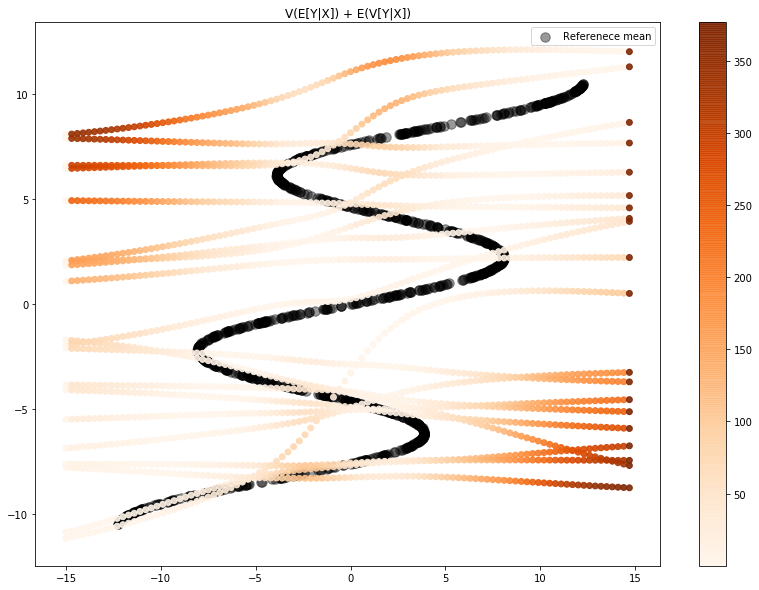

In [19]:
plt.figure(figsize=(14, 10))
plt.title("V(E[Y|X]) + E(V[Y|X])")
plt.scatter(x_data, r_data, c='black', s=90, alpha=0.4, label="Referenece mean")
for i in range(out_mu_test.shape[1]):
    plt.scatter(x_sample, out_mu_test[:,i], c=y_total_unct_mat[:,i], cmap="Oranges", s=35, alpha=0.9)

plt.legend()
plt.colorbar()

So far, we calculated one representive value throughout all mixtures per one input x.  
How about individual mixtures? The graph above shows its own aleatoric, epistemic uncertainties of **each mixture**.

In [27]:
"""fig, ax = plt.subplots()

l2, = 
ax2.legend([l2], ["mean path"])
l3, = ax3.plot(x_sample, y_unct_test, 'g-', linewidth=2.0, alpha=1)
ax3.legend([l3], ["V(E[Y|X])+E(V[Y|X])"])
l4, = ax4.plot(x_sample, y_alea_test, 'g-', linewidth=2.0, alpha=1)
ax4.legend([l4], ["E(V[Y|X])"])
l5, = ax5.plot(x_sample, y_epis_test, 'g-', linewidth=2.0, alpha=1)
ax5.legend([l5], ["V(E[Y|X])"])
"""

'fig, ax = plt.subplots()\n\nl2, = \nax2.legend([l2], ["mean path"])\nl3, = ax3.plot(x_sample, y_unct_test, \'g-\', linewidth=2.0, alpha=1)\nax3.legend([l3], ["V(E[Y|X])+E(V[Y|X])"])\nl4, = ax4.plot(x_sample, y_alea_test, \'g-\', linewidth=2.0, alpha=1)\nax4.legend([l4], ["E(V[Y|X])"])\nl5, = ax5.plot(x_sample, y_epis_test, \'g-\', linewidth=2.0, alpha=1)\nax5.legend([l5], ["V(E[Y|X])"])\n'